#  Time Series Modeling of Monthly Real Estate Construction Data


In [1]:
# Install and load required packages
install.packages("readxl")
install.packages("forecast")
install.packages("tseries")
install.packages("ggplot2")
install.packages("strucchange")

library(tseries)
library(strucchange)
library(readxl)
library(forecast)
library(tseries)
library(ggplot2)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sandwich’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [4]:
list.files("/content")


[1] "sample_data"                            
[2] "value of real estate constructions.xlsx"

In [5]:
# Read the file using the correct path
data_realestate <- read_excel("/content/value of real estate constructions.xlsx")

# Preview the first few rows
head(data_realestate)

29952,105.4
<dttm>,<dbl>
1982-02-01,95.4
1982-03-01,145.0
1982-04-01,175.8
1982-05-01,170.2
1982-06-01,163.2
1982-07-01,160.7


In [6]:
head(data_realestate)
str(data_realestate)
summary(data_realestate)

29952,105.4
<dttm>,<dbl>
1982-02-01,95.4
1982-03-01,145.0
1982-04-01,175.8
1982-05-01,170.2
1982-06-01,163.2
1982-07-01,160.7


tibble [396 × 2] (S3: tbl_df/tbl/data.frame)
 $ 29952: POSIXct[1:396], format: "1982-02-01" "1982-03-01" ...
 $ 105.4: num [1:396] 95.4 145 175.8 170.2 163.2 ...


     29952                         105.4      
 Min.   :1982-02-01 00:00:00   Min.   : 31.9  
 1st Qu.:1990-04-23 12:00:00   1st Qu.: 84.4  
 Median :1998-07-16 12:00:00   Median :112.3  
 Mean   :1998-07-17 00:25:27   Mean   :112.3  
 3rd Qu.:2006-10-08 18:00:00   3rd Qu.:140.6  
 Max.   :2015-01-01 00:00:00   Max.   :197.9  

##  Phase 1: Statistical and Graphical Analysis

###  1.  Graphical Analysis – *Chronogramme*

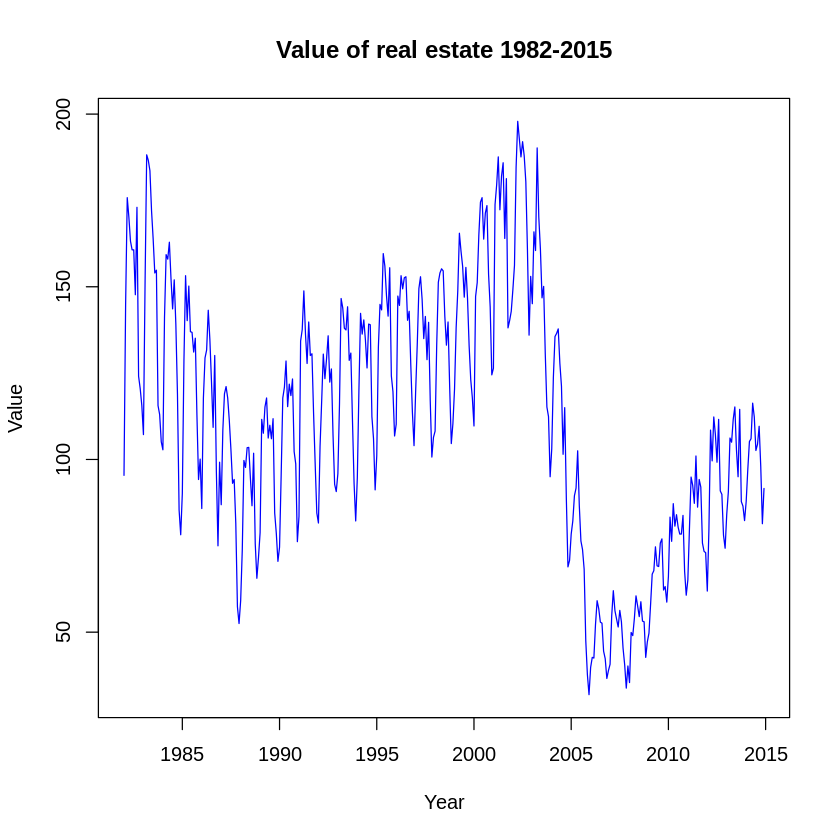

In [8]:
data_realestate.ts<-ts(data_realestate[[2]], start = c(1982, 1), frequency = 12)
plot(data_realestate.ts,
     main = "Value of real estate 1982-2015",
     ylab = "Value",
     xlab = "Year",
     col = "blue",
     type = "l")


###  Chronogramme Interpretation

- The series shows **seasonality** and an **irregular trend**.
- A **strong upward trend** peaks around **2004**, followed by a **sudden drop** → clear **structural break**.
- After 2008, we see a **partial recovery**.
- This pattern confirms the need for **breakpoint modeling**, not just simple trend removal.


###  2.  Statistical Analysis – Correlogramme (ACF)



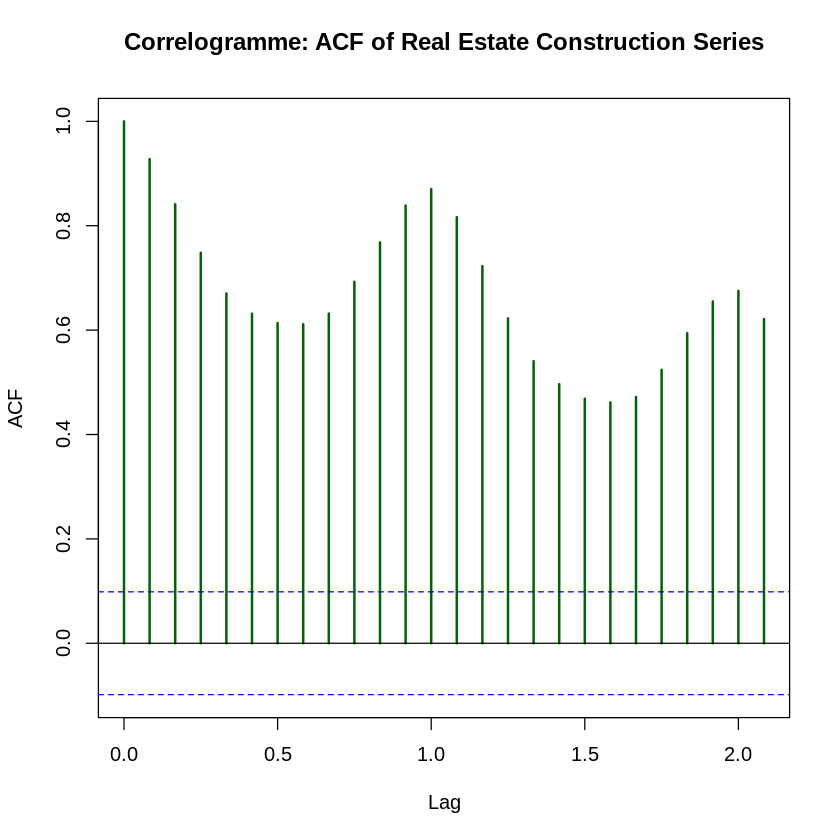

In [9]:
# Autocorrelation Function (ACF)
acf(
  data_realestate.ts,
  main = "Correlogramme: ACF of Real Estate Construction Series",
  col = "darkgreen",
  lwd = 2
)

###  ACF Interpretation

- The ACF shows **slow decay** → clear indication of a **trend**.
- Repeating peaks suggest **strong seasonality** .

  


### 3. Time Series Decomposition

###  Additive Decomposition

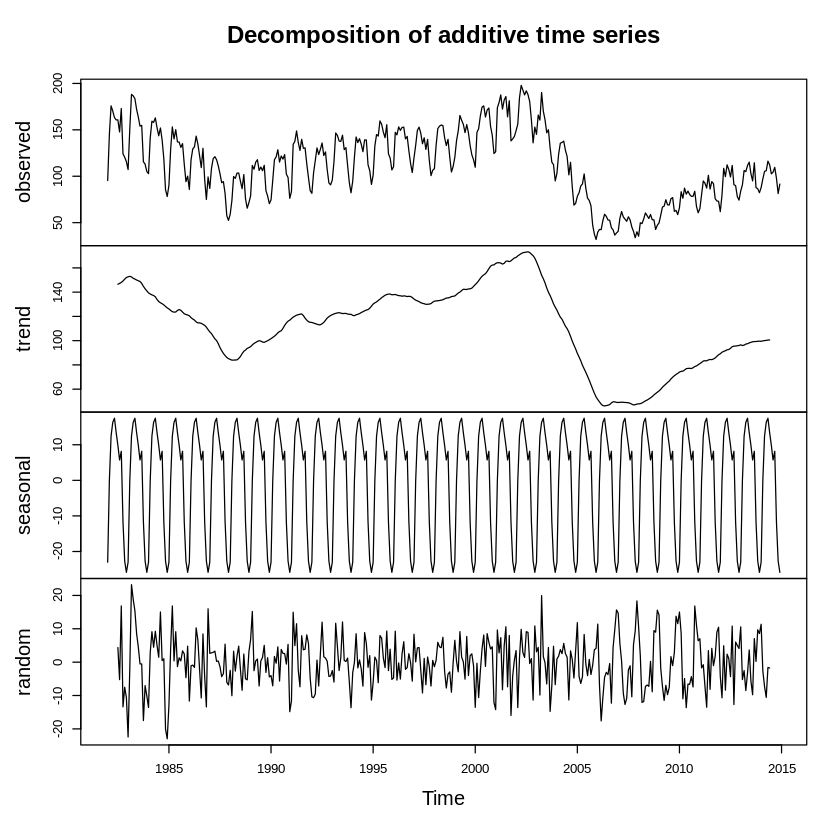

In [10]:
# Decompose the series additively
decomp_add <- decompose(data_realestate.ts, type = "additive")

# Plot without custom title
plot(decomp_add)

# Extract residuals (random component)
residuals_add <- na.omit(decomp_add$random)


###  Multiplicative Decomposition

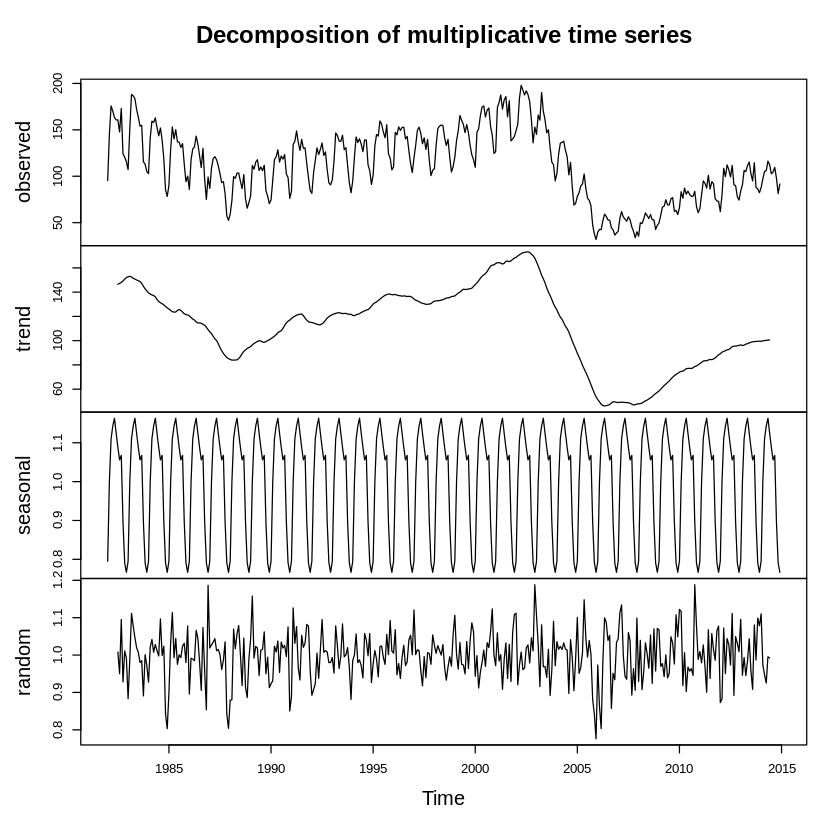

In [12]:
# Decompose the series multiplicatively
decomp_mult <- decompose(data_realestate.ts, type = "multiplicative")

# Plot without 'main'
plot(decomp_mult)

# Extract residuals
residuals_mult <- na.omit(decomp_mult$random)


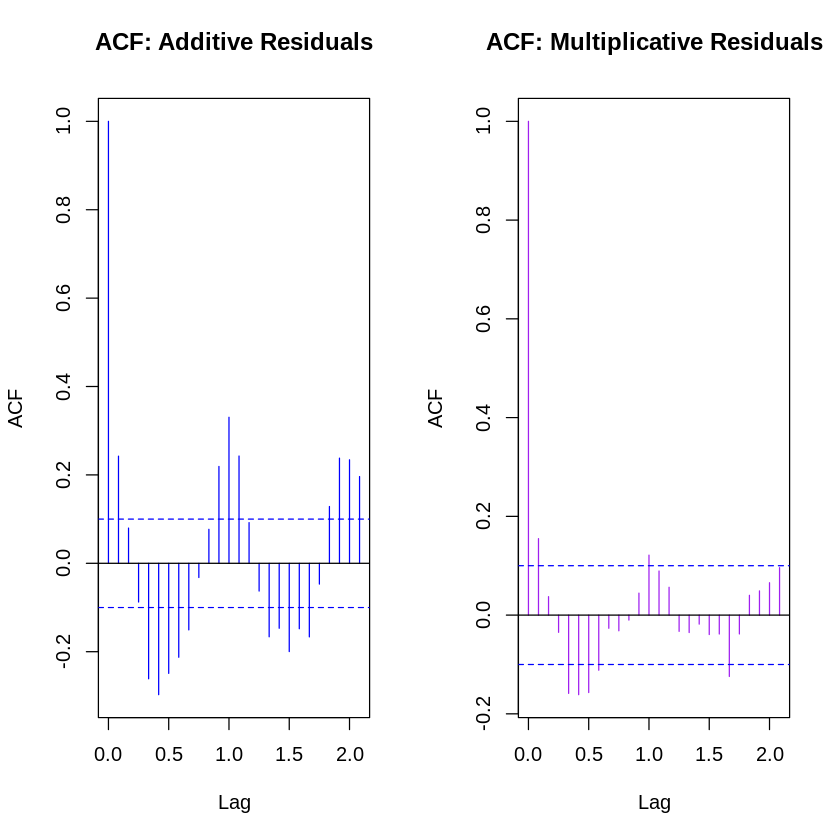

In [13]:
# Set up the plotting area to have 1 row and 2 columns
par(mfrow = c(1, 2))

# Plot ACF of additive residuals
acf(
  residuals_add,
  main = "ACF: Additive Residuals",
  col = "blue"
)

# Plot ACF of multiplicative residuals
acf(
  residuals_mult,
  main = "ACF: Multiplicative Residuals",
  col = "purple"
)

# Reset plotting area to default (optional)
par(mfrow = c(1, 1))


###  ACF of Residuals – Interpretation

-  **Additive**: Residuals still show autocorrelation → not fully cleaned.
-  **Multiplicative**: Residuals are closer to white noise → better result.

>  **Multiplicative decomposition is more effective** for this time series.


##  Phase 2 – Adjustment of the Time Series




###  Step 1: Create Time Index
- Create a time variable `t`.


In [14]:
# Time series index
t <- 1:length(data_realestate.ts)



###  Step 2: Detect Structural Breaks

- Apply `breakpoints()` to the raw series
- Visualize the fitted breakpoint segments over the original series
(add quadratic)

In [15]:
p.break<-breakpoints(log(data_realestate.ts)~t)
p.break


	 Optimal 4-segment partition: 

Call:
breakpoints.formula(formula = log(data_realestate.ts) ~ t)

Breakpoints at observation number:
85 242 301 

Corresponding to breakdates:
1989(1) 2002(2) 2007(1) 

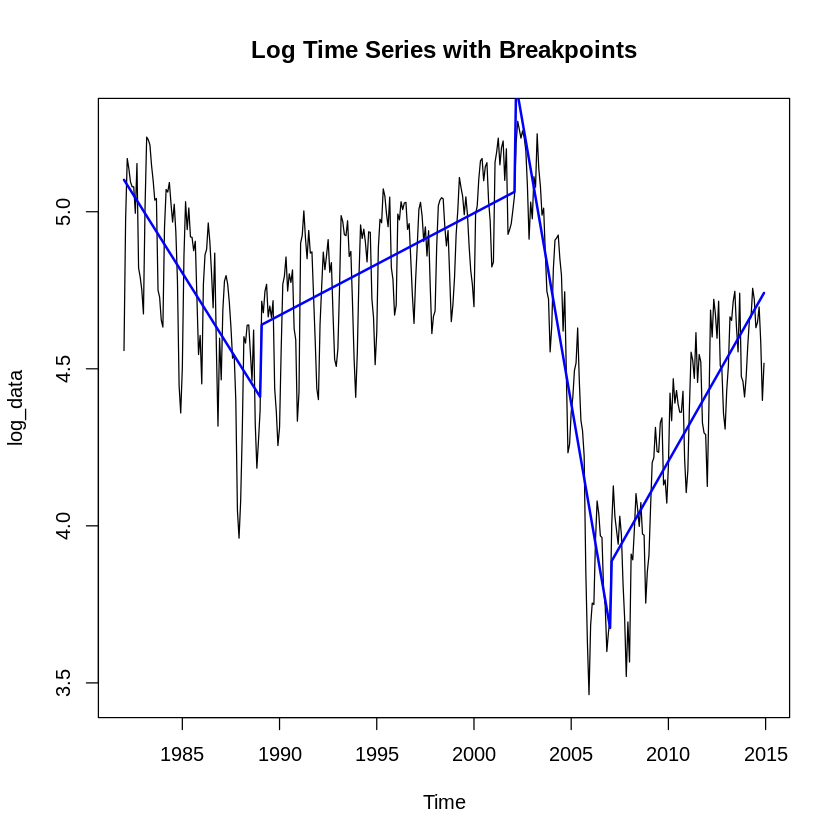

In [16]:
log_data <- log(data_realestate.ts)
plot(log_data, main = "Log Time Series with Breakpoints")
lines(fitted(p.break), col = "blue", lwd = 2)


In [17]:
test<-lm(log(data_realestate.ts)~breakfactor(p.break)*t)
summary(test)


Call:
lm(formula = log(data_realestate.ts) ~ breakfactor(p.break) * 
    t)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60005 -0.11253  0.03423  0.13359  0.35859 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.1097089  0.0386704  132.13   <2e-16 ***
breakfactor(p.break)segment2   -0.7024840  0.0655600  -10.71   <2e-16 ***
breakfactor(p.break)segment3    7.5360251  0.3701613   20.36   <2e-16 ***
breakfactor(p.break)segment4   -3.9635155  0.2346314  -16.89   <2e-16 ***
t                              -0.0082232  0.0007811  -10.53   <2e-16 ***
breakfactor(p.break)segment2:t  0.0109339  0.0008408   13.00   <2e-16 ***
breakfactor(p.break)segment3:t -0.0215791  0.0015604  -13.83   <2e-16 ***
breakfactor(p.break)segment4:t  0.0173022  0.0010233   16.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1767 on 388 degrees of freedom
Multiple R-s

###  Step 3: Model Seasonality Using Fourier Terms

- Generate harmonic terms (sine and cosine) with 6 seasonal components.
- Remove selected harmonics to reduce multicollinearity

In [19]:
MCos <- matrix(0, length(data_realestate.ts), 6)
MSin <- matrix(0, length(data_realestate.ts), 6)

for (i in 1:6) {
  MCos[, i] <- cos(2 * pi * t / (12 / i))
  MSin[, i] <- sin(2 * pi * t / (12 / i))
}


###  Step 4: Fit Regression Model

- Fit a linear model using:
  - **Breakpoints for trend shifts**
  - **Fourier terms for seasonality**
- This isolates the structural and seasonal components

In [20]:
modell<- lm(log(data_realestate.ts) ~ breakfactor(p.break) * t + MCos + MSin)
summary(modell)


Call:
lm(formula = log(data_realestate.ts) ~ breakfactor(p.break) * 
    t + MCos + MSin)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37447 -0.05830  0.00828  0.05851  0.24178 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.092e+00  2.184e-02 233.137  < 2e-16 ***
breakfactor(p.break)segment2   -7.159e-01  3.699e-02 -19.354  < 2e-16 ***
breakfactor(p.break)segment3    7.179e+00  2.093e-01  34.303  < 2e-16 ***
breakfactor(p.break)segment4   -4.086e+00  1.325e-01 -30.835  < 2e-16 ***
t                              -7.743e-03  4.413e-04 -17.544  < 2e-16 ***
MCos1                          -1.855e-01  7.102e-03 -26.114  < 2e-16 ***
MCos2                          -7.733e-02  7.089e-03 -10.909  < 2e-16 ***
MCos3                          -1.384e-02  7.084e-03  -1.954   0.0515 .  
MCos4                           1.672e-02  7.086e-03   2.359   0.0188 *  
MCos5                           1.309e-02  7.089e-

In [21]:
modell2 <- lm(log(data_realestate.ts) ~ breakfactor(p.break) * t +
                   MCos[,1] + MCos[,2] + MCos[,4] + MCos[,4] + MCos[,5] +
                   MSin[,1] + MSin[,4] + MSin[,5])
summary(modell2)



Call:
lm(formula = log(data_realestate.ts) ~ breakfactor(p.break) * 
    t + MCos[, 1] + MCos[, 2] + MCos[, 4] + MCos[, 4] + MCos[, 
    5] + MSin[, 1] + MSin[, 4] + MSin[, 5])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38914 -0.05557  0.00760  0.06178  0.25429 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.0920919  0.0218473 233.076  < 2e-16 ***
breakfactor(p.break)segment2   -0.7163323  0.0370050 -19.358  < 2e-16 ***
breakfactor(p.break)segment3    7.1751681  0.2093058  34.281  < 2e-16 ***
breakfactor(p.break)segment4   -4.0823995  0.1325414 -30.801  < 2e-16 ***
t                              -0.0077535  0.0004415 -17.564  < 2e-16 ***
MCos[, 1]                      -0.1853789  0.0071045 -26.093  < 2e-16 ***
MCos[, 2]                      -0.0772956  0.0070923 -10.899  < 2e-16 ***
MCos[, 4]                       0.0166137  0.0070873   2.344   0.0196 *  
MCos[, 5]                       0.012

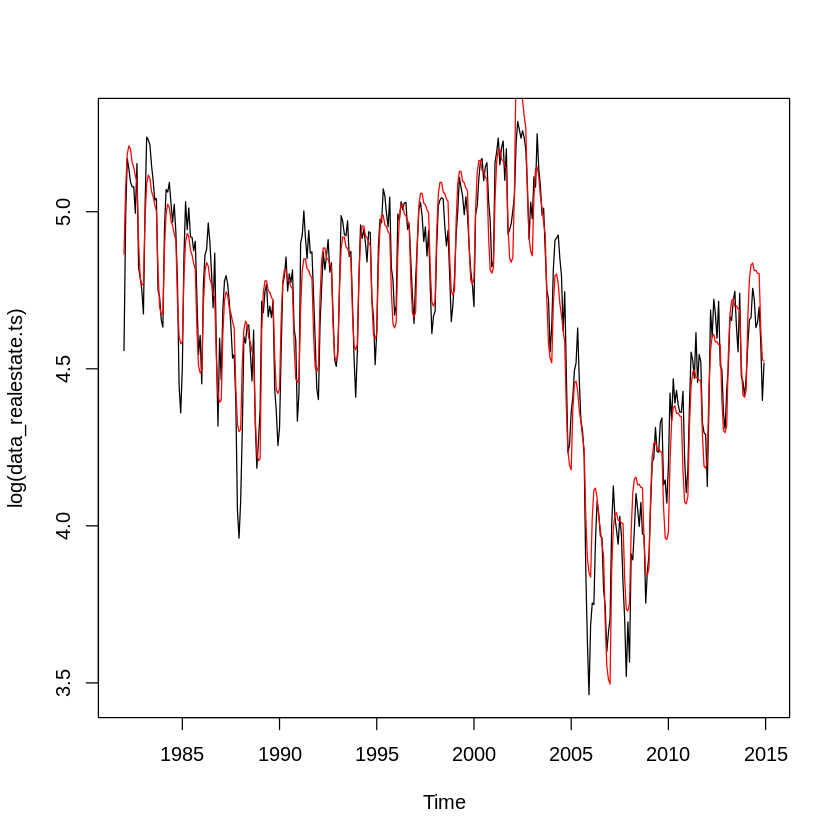

In [22]:
plot(log(data_realestate.ts))
points(time(data_realestate.ts),fitted(modell2),type="l",col="red")

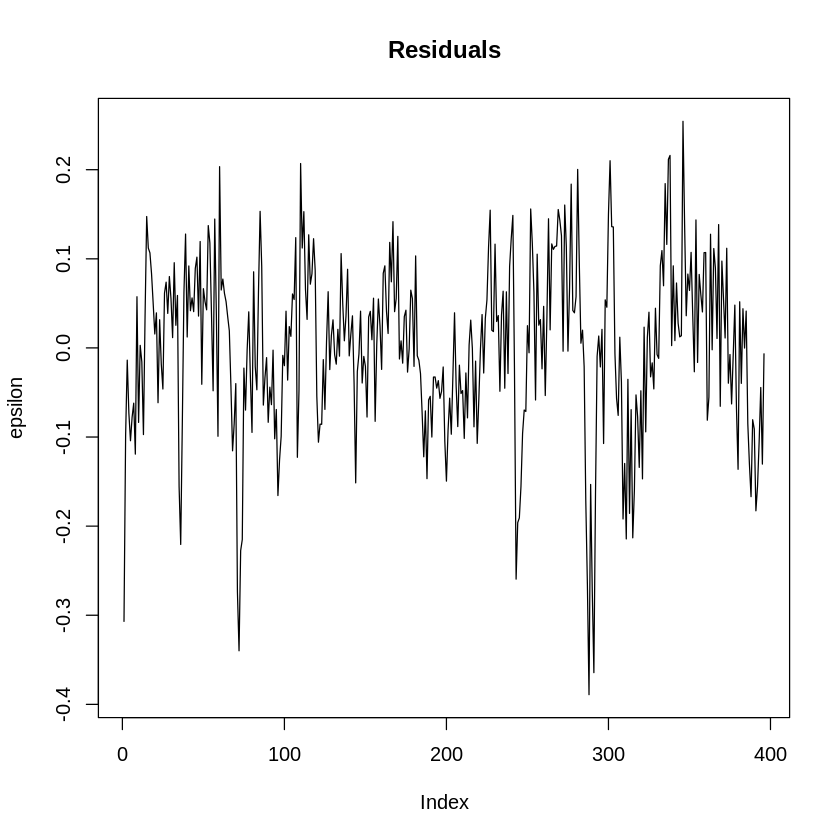

In [23]:
epsilon2 <- modell2$residuals
plot(epsilon2, type = "l", main = "Residuals", ylab = "epsilon", xlab = "Index")


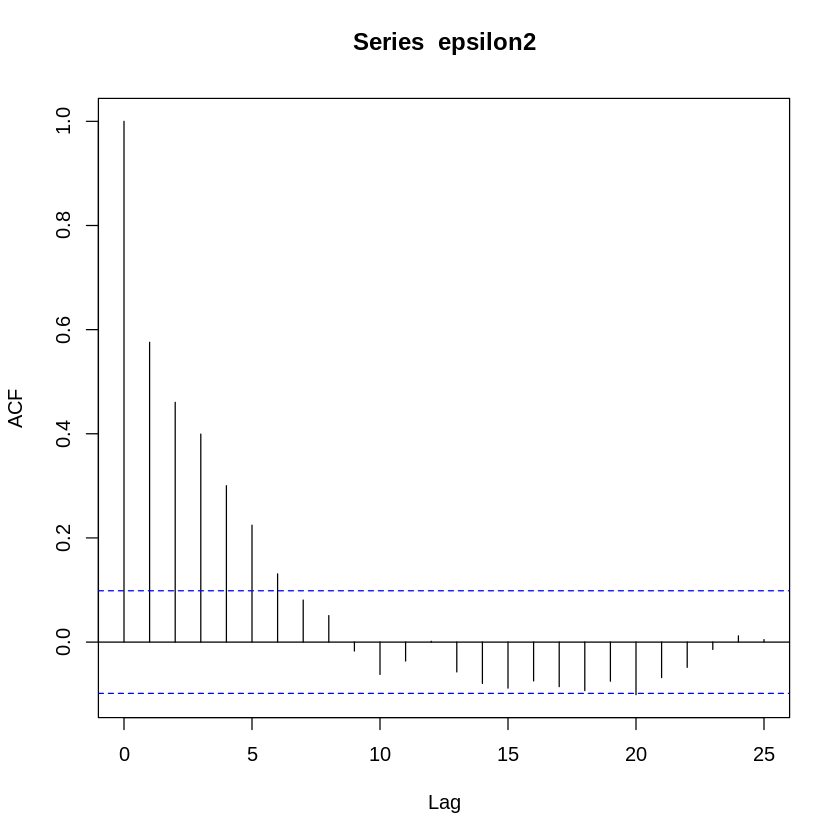

In [24]:
acf(epsilon2)

In [25]:
adf.test(epsilon2)

Warning message in adf.test(epsilon2):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  epsilon2
Dickey-Fuller = -5.6868, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


-> p_value <0.05 we reject H0 and accept H1 -> the residuals are stationary, we proceed with arma modeling

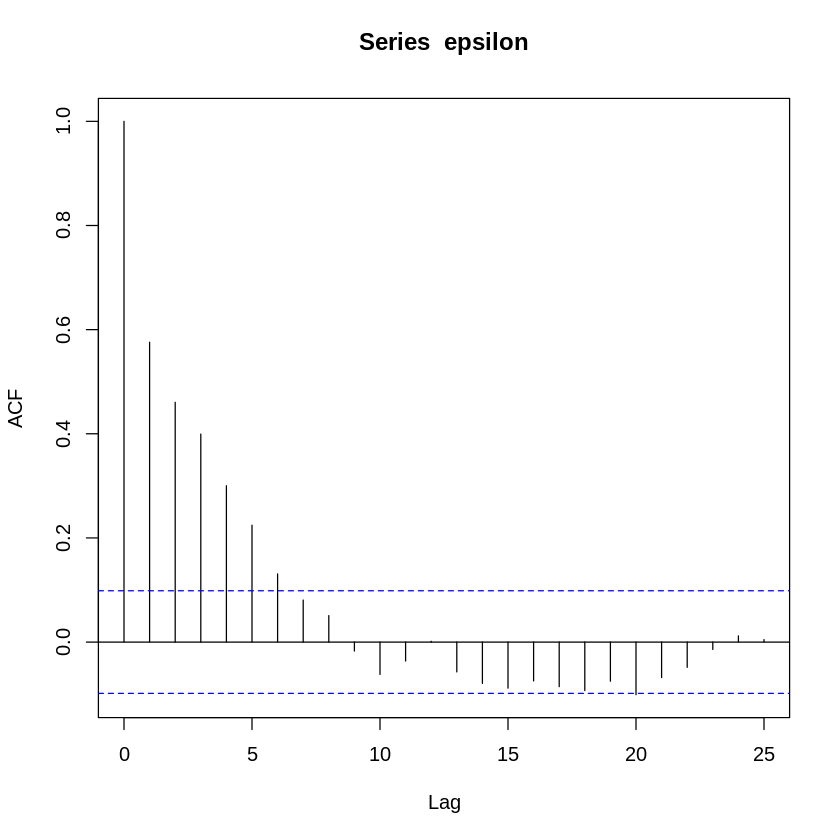

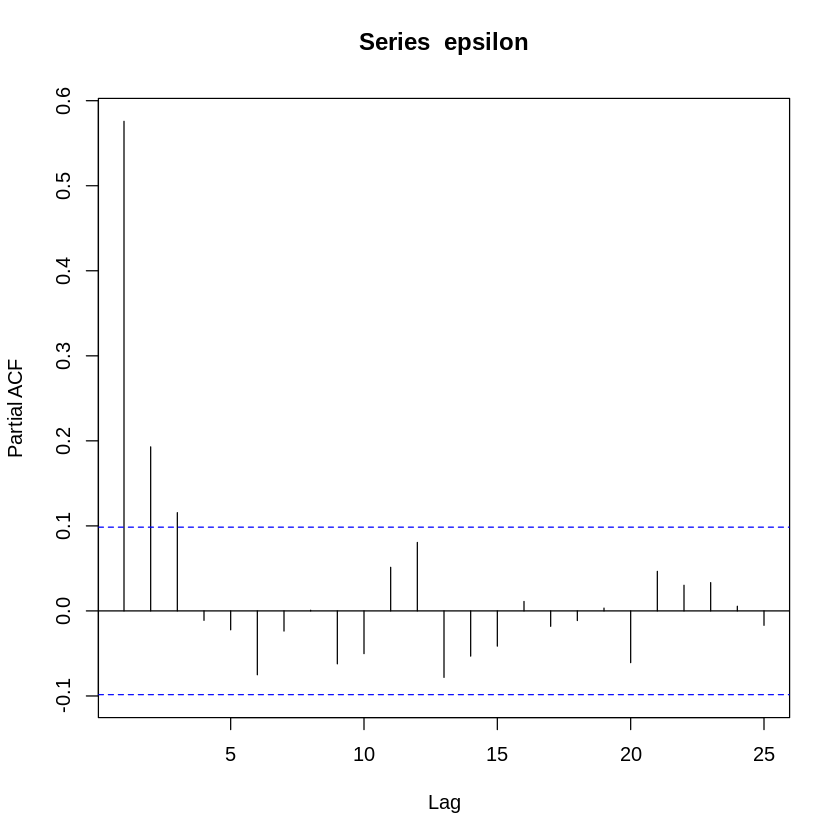

In [ ]:
acf(epsilon2)
pacf(epsilon2)

1. ACF :
Shows significant spikes up to lag 5–6, then tails off.

This tailing behavior suggests the presence of an AR (autoregressive) component.

2. PACF:
Has a significant spike at lag 1, then mostly within bounds (non-significant).

This suggests MA(1) behavior (because PACF cuts off at lag 1).

In [26]:
# Basic models
model_001 <- Arima(epsilon2, order = c(0, 0, 1))
model_002 <- Arima(epsilon2, order = c(0, 0, 2))
model_004 <- Arima(epsilon2, order = c(0, 0, 4))

# Add AR terms
model_101 <- Arima(epsilon2, order = c(1, 0, 1))
model_102 <- Arima(epsilon2, order = c(1, 0, 2))
model_104 <- Arima(epsilon2, order = c(1, 0, 4))

# Try higher AR
model_201 <- Arima(epsilon2, order = c(2, 0, 1))
model_204 <- Arima(epsilon2, order = c(2, 0, 4))


In [27]:
summary(model_001)


Series: epsilon2 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1     mean
      0.4419  -0.0002
s.e.  0.0385   0.0062

sigma^2 = 0.007352:  log likelihood = 411.74
AIC=-817.47   AICc=-817.41   BIC=-805.53

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0002302591 0.08552449 0.06676332 158.6209 216.3034 0.9370767
                  ACF1
Training set 0.1224629

In [28]:
summary(model_002)

Series: epsilon2 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
         ma1     ma2     mean
      0.4617  0.2594  -0.0005
s.e.  0.0501  0.0459   0.0071

sigma^2 = 0.006819:  log likelihood = 427.09
AIC=-846.17   AICc=-846.07   BIC=-830.25

Training set error measures:
                       ME       RMSE       MAE      MPE     MAPE      MASE
Training set 0.0003791077 0.08226615 0.0637697 80.66401 168.8775 0.8950589
                   ACF1
Training set 0.05171353

In [29]:
summary(model_004)

Series: epsilon2 
ARIMA(0,0,4) with non-zero mean 

Coefficients:
         ma1     ma2     ma3     ma4     mean
      0.4520  0.3227  0.3017  0.1602  -0.0010
s.e.  0.0502  0.0532  0.0514  0.0444   0.0088

sigma^2 = 0.00628:  log likelihood = 444.33
AIC=-876.66   AICc=-876.44   BIC=-852.77

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0005651761 0.07874414 0.06091933 129.1691 232.4826 0.8550516
                    ACF1
Training set 0.008788944

In [30]:
summary(model_101)

Series: epsilon2 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1      ma1     mean
      0.8119  -0.3552  -0.0024
s.e.  0.0450   0.0698   0.0133

sigma^2 = 0.006072:  log likelihood = 449.94
AIC=-891.88   AICc=-891.77   BIC=-875.95

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0008923169 0.07762884 0.06017897 66.09846 210.3086 0.8446602
                    ACF1
Training set -0.01534646

In [31]:
summary(model_102)

Series: epsilon2 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1      ma1     ma2     mean
      0.8075  -0.3550  0.0106  -0.0025
s.e.  0.0513   0.0708  0.0593   0.0132

sigma^2 = 0.006087:  log likelihood = 449.95
AIC=-889.91   AICc=-889.75   BIC=-870

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0009446543 0.07762565 0.06015623 65.19741 209.3622 0.8443409
                    ACF1
Training set -0.01189516

In [32]:
summary(model_104)

Series: epsilon2 
ARIMA(1,0,4) with non-zero mean 

Coefficients:
         ar1      ma1     ma2     ma3     ma4     mean
      0.7417  -0.2922  0.0114  0.0936  0.0240  -0.0020
s.e.  0.0852   0.0964  0.0629  0.0588  0.0613   0.0125

sigma^2 = 0.006078:  log likelihood = 451.26
AIC=-888.53   AICc=-888.24   BIC=-860.66

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0008471486 0.07736639 0.05992331 76.52975 216.7952 0.8410718
                    ACF1
Training set -0.01084571

In [33]:
summary(model_201)

Series: epsilon2 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1     ar2      ma1     mean
      0.7887  0.0163  -0.3349  -0.0025
s.e.  0.1616  0.1102   0.1541   0.0132

sigma^2 = 0.006087:  log likelihood = 449.95
AIC=-889.9   AICc=-889.74   BIC=-869.99

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0009254818 0.07762675 0.06016446 65.47508 209.6261 0.8444565
                    ACF1
Training set -0.01295329

In [34]:
summary(model_204)

Series: epsilon2 
ARIMA(2,0,4) with non-zero mean 

Coefficients:
         ar1      ar2      ma1     ma2     ma3      ma4     mean
      1.8085  -0.8218  -1.3911  0.3671  0.0941  -0.0701  -0.0001
s.e.  0.0592   0.0581   0.0773  0.0938  0.0897   0.0617   0.0015

sigma^2 = 0.005891:  log likelihood = 456.56
AIC=-897.12   AICc=-896.75   BIC=-865.27

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.0001526846 0.07606978 0.05898255 29.45939 194.6218 0.8278675
                    ACF1
Training set -0.01237918

Best Model: ARIMA(2,0,4)
Lowest AIC: -897.12 → best overall model.

Lowest σ² (residual variance): 0.005891.

Lowest RMSE & MAE.

Low ACF1 → residuals resemble white noise.

Coefficients are significant (low standard errors).




	Ljung-Box test

data:  Residuals from ARIMA(2,0,4) with non-zero mean
Q* = 4.4187, df = 4, p-value = 0.3523

Model df: 6.   Total lags used: 10



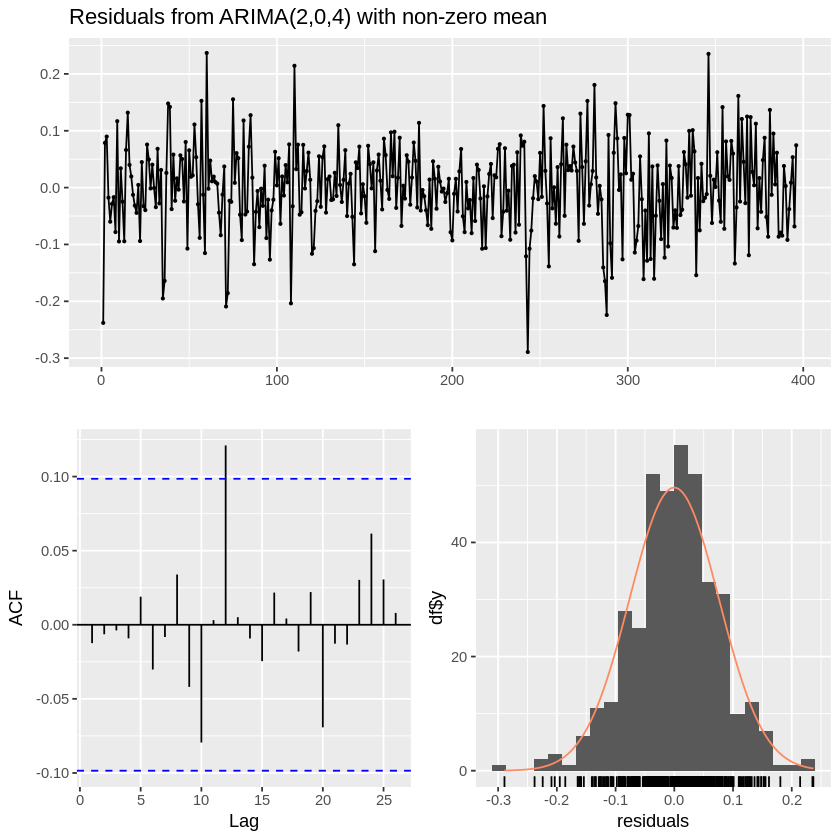

In [35]:
checkresiduals(model_204)

-> The model's residuals are in fact white noise, which means the model fits the data well.


 Ready for next step: **Forecasting future values** with confidence!
